In [ ]:
%cd /content/drive/MyDrive/M.Tech CS_2022-23/Project/One Class Learning

/content/drive/MyDrive/M.Tech CS_2022-23/Project/One Class Learning


In [ ]:
import numpy as np
import pandas as pd 
import random 
import os
from tqdm import tqdm
# from functools import partial
import matplotlib.pyplot as plt
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

from sklearn.neighbors import KNeighborsClassifier
# from siamese_network import SiameseNetwork

pio.renderers.default = 'colab'

## 1. Import dataset

In [ ]:
data_path = './data'

In [ ]:
train_dataset = torchvision.datasets.MNIST(data_path, train=True)
test_dataset  = torchvision.datasets.MNIST(data_path, train=False)

In [ ]:
# fig, axs = plt.subplots(5, 5, figsize=(8,8))
# for ax in axs.flatten():
#     # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
#     img, label = random.choice(train_dataset)
#     ax.imshow(np.array(img), cmap='gist_gray')
#     ax.set_title(f'Label: {label}')
#     ax.set_xticks([])
#     ax.set_yticks([])
# plt.tight_layout()

In [ ]:
train_transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
test_transform = transforms.ToTensor()

In [ ]:
def get_class_c(x, y, c):    
  y = np.array(y)    
  pos_c = np.argwhere(y == c)    
  pos_c = list(pos_c[:, 0])    
  class_c_data = [x[i] for i in pos_c]
  return class_c_data, [c]*len(pos_c)


class DatasetMaker(Dataset):
  def __init__(self, data, targets, transform_func=None):
    super().__init__()    
    self.data = data
    self.targets = targets
    self.transform_func = transform_func    

  def __getitem__(self, idx):
    img, target = self.data[idx], self.targets[idx]
    if self.transform_func:    
      img = self.transform_func(img)    
    return img, target

  def __len__(self):
    return len(self.targets)


def prepare_oc_dataset(dataset, class_label): 
  # get single class (class_label) data
  data, targets = get_class_c(dataset.data, dataset.targets, class_label)      
  return DatasetMaker(data, targets, train_transform)

In [ ]:
true_label = 8

train_dataset = prepare_oc_dataset(train_dataset, true_label)
test_dataset.transform = test_transform

In [ ]:
len(train_dataset)

5851

In [ ]:
train_data, val_data = random_split(train_dataset, [0.9, 0.1])

In [ ]:
batch_size = 256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

## 2. Define Convolutional Autoencoder

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, feature_dim, fc2_input_dim=128):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, fc2_input_dim),
            nn.ReLU(inplace=True),
            # Second linear layer
            nn.Linear(fc2_input_dim, feature_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, feature_dim, fc2_input_dim=128):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(feature_dim, fc2_input_dim),
            nn.ReLU(inplace=True),
            # Second linear layer
            nn.Linear(fc2_input_dim, 3 * 3 * 32),
            nn.ReLU(inplace=True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

## 3. Initialize Loss function and the optimizer

In [ ]:
### Set the random seed for reproducible results
torch.manual_seed(3)

### Initialize the two networks
feature_dim = 64

#model = Autoencoder(feature_dim=feature_dim)
encoder = Encoder(feature_dim)
decoder = Decoder(feature_dim)

In [ ]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image

img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
#dec_img = model(img)
print('Decoded image shape:', dec_img.shape)

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.01

params_to_optimize = [{'params': encoder.parameters()}, {'params': decoder.parameters()}]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device);

Selected device: cuda


## 4. Train and evaluate model

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
  # Set train mode for both the encoder and the decoder
  encoder.train()
  decoder.train()    
  total_num, total_loss = 0, 0.

  # Iterate the dataloader (we do not need the label values, this is unsupervised learning)    
  for image_batch, _ in (train_bar := tqdm(dataloader)):
    image_batch = image_batch.to(device)

    # Encode data
    encoded_data = encoder(image_batch)
    # Decode data
    decoded_data = decoder(encoded_data)

    # Evaluate loss
    loss = loss_fn(decoded_data, image_batch)
    # loss = loss_fn(decoded_data, image_batch[torch.randperm(image_batch.size()[0])])

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print batch loss      
    total_num += image_batch.shape[0]
    total_loss += loss.item() * image_batch.shape[0]
    train_bar.set_description(f'Train Epoch: [{epoch+1}/{num_epochs}] Loss: {total_loss / total_num :.4f}')
  
  return total_loss / total_num

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
  # Set evaluation mode for encoder and decoder
  encoder.eval()
  decoder.eval()
  total_num, total_loss = 0, 0.
  with torch.no_grad(): # No need to track the gradients      
    for image_batch, _ in (test_bar := tqdm(dataloader)):
      # Move tensor to the proper device
      image_batch = image_batch.to(device)

      # Encode data
      encoded_data = encoder(image_batch)
      # Decode data
      decoded_data = decoder(encoded_data)

      loss = loss_fn(decoded_data, image_batch)

      total_num += image_batch.shape[0]
      total_loss += loss.item() * image_batch.shape[0]
      test_bar.set_description(f'Test Epoch: [{epoch+1}/{num_epochs}] Loss: {total_loss / total_num :.4f}')

  return total_loss / total_num

In [ ]:
def plot_original_images(num_classes=10):
  plt.figure(figsize=(16, 4.5))  
  _targets = test_dataset.targets.numpy()
  t_idx = {}
  # gets the first samples of each of the `n` categories in the `test_dataset`;
  for i in range(num_classes):
    t_idx[i] = np.where(_targets == i)[0][0]
    ax = plt.subplot(2, num_classes, i+1)
    # `unsqueeze` to get the batch dimension
    # (Note that we're not using a dataloader to get these test images)
    img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)  
    plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    # ax.set_title('Original images')
  plt.show()
  return t_idx

def plot_ae_outputs(encoder, decoder, t_idx, num_classes=10):
  plt.figure(figsize=(16, 4.5))
  encoder.eval()
  decoder.eval()    
  for i in range(num_classes):    
    ax = plt.subplot(2, num_classes, i+1+num_classes)
    with torch.no_grad():
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      rec_img  = decoder(encoder(img))
    plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    # if i == n//2:
    #   ax.set_title('Reconstructed images')
  plt.show()

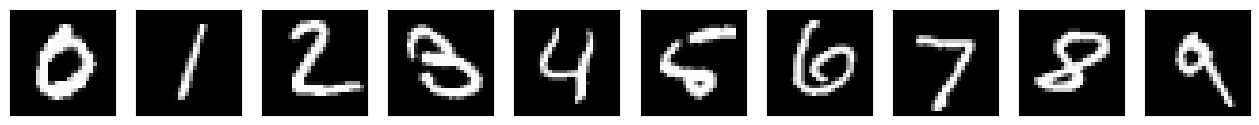

Test Epoch: [1/35] Loss: 0.0749: 100%|██████████| 3/3 [00:00<00:00, 25.47it/s]


Test Epoch: [2/35] Loss: 0.0678: 100%|██████████| 3/3 [00:00<00:00, 28.20it/s]


Test Epoch: [3/35] Loss: 0.0633: 100%|██████████| 3/3 [00:00<00:00, 25.89it/s]


Test Epoch: [4/35] Loss: 0.0577: 100%|██████████| 3/3 [00:00<00:00, 16.22it/s]


Test Epoch: [5/35] Loss: 0.0543: 100%|██████████| 3/3 [00:00<00:00, 21.43it/s]


Test Epoch: [6/35] Loss: 0.0557: 100%|██████████| 3/3 [00:00<00:00, 18.65it/s]


Test Epoch: [7/35] Loss: 0.0567: 100%|██████████| 3/3 [00:00<00:00, 27.33it/s]


Test Epoch: [8/35] Loss: 0.0475: 100%|██████████| 3/3 [00:00<00:00, 26.55it/s]


Test Epoch: [9/35] Loss: 0.0451: 100%|██████████| 3/3 [00:00<00:00, 27.33it/s]


Test Epoch: [10/35] Loss: 0.0439: 100%|██████████| 3/3 [00:00<00:00, 23.30it/s]


Test Epoch: [11/35] Loss: 0.0402: 100%|██████████| 3/3 [00:00<00:00, 28.05it/s]


Test Epoch: [12/35] Loss: 0.0365: 100%|██████████| 3/3 [00:00<00:00, 26.46it/s]


Test Epoch: [13/35] Loss: 0.0441: 100%|██████████| 3/3 [00:00<00:00, 25.89it/s]


Test Epoch: [14/35] Loss: 0.0333: 100%|██████████| 3/3 [00:00<00:00, 24.59it/s]


Test Epoch: [15/35] Loss: 0.0304: 100%|██████████| 3/3 [00:00<00:00, 16.87it/s]


Test Epoch: [16/35] Loss: 0.0294: 100%|██████████| 3/3 [00:00<00:00, 16.96it/s]


Test Epoch: [17/35] Loss: 0.0288: 100%|██████████| 3/3 [00:00<00:00, 23.67it/s]


Test Epoch: [18/35] Loss: 0.0295: 100%|██████████| 3/3 [00:00<00:00, 26.51it/s]


Test Epoch: [19/35] Loss: 0.0279: 100%|██████████| 3/3 [00:00<00:00, 26.82it/s]


Test Epoch: [20/35] Loss: 0.0265: 100%|██████████| 3/3 [00:00<00:00, 25.66it/s]


Test Epoch: [21/35] Loss: 0.0252: 100%|██████████| 3/3 [00:00<00:00, 24.66it/s]


Test Epoch: [22/35] Loss: 0.0239: 100%|██████████| 3/3 [00:00<00:00, 24.49it/s]


Test Epoch: [23/35] Loss: 0.0244: 100%|██████████| 3/3 [00:00<00:00, 26.16it/s]


Test Epoch: [24/35] Loss: 0.0233: 100%|██████████| 3/3 [00:00<00:00, 25.68it/s]


Test Epoch: [25/35] Loss: 0.0209: 100%|██████████| 3/3 [00:00<00:00, 17.06it/s]


Test Epoch: [26/35] Loss: 0.0205: 100%|██████████| 3/3 [00:00<00:00, 19.17it/s]


Test Epoch: [27/35] Loss: 0.0190: 100%|██████████| 3/3 [00:00<00:00, 20.49it/s]


Test Epoch: [28/35] Loss: 0.0197: 100%|██████████| 3/3 [00:00<00:00, 26.34it/s]


Test Epoch: [29/35] Loss: 0.0185: 100%|██████████| 3/3 [00:00<00:00, 26.51it/s]


Test Epoch: [30/35] Loss: 0.0170: 100%|██████████| 3/3 [00:00<00:00, 23.05it/s]


Test Epoch: [31/35] Loss: 0.0179: 100%|██████████| 3/3 [00:00<00:00, 26.24it/s]


Test Epoch: [32/35] Loss: 0.0166: 100%|██████████| 3/3 [00:00<00:00, 26.18it/s]


Test Epoch: [33/35] Loss: 0.0166: 100%|██████████| 3/3 [00:00<00:00, 25.55it/s]


Test Epoch: [34/35] Loss: 0.0161: 100%|██████████| 3/3 [00:00<00:00, 25.35it/s]


Test Epoch: [35/35] Loss: 0.0176: 100%|██████████| 3/3 [00:00<00:00, 25.73it/s]


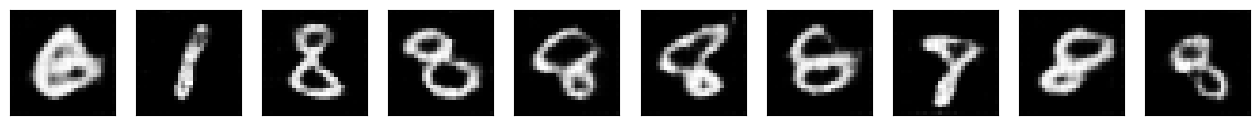

In [ ]:
num_epochs = 35
history = {'train_loss':[],'val_loss':[]}

t_idx = plot_original_images()

for epoch in range(num_epochs):  
  train_loss = train_epoch(encoder, decoder, device, train_loader, loss_fn, optim)  
  val_loss = test_epoch(encoder, decoder, device, val_loader, loss_fn)
  print()
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)
  
plot_ae_outputs(encoder, decoder, t_idx)

In [ ]:
test_epoch(encoder, decoder, device, test_loader, loss_fn).item()

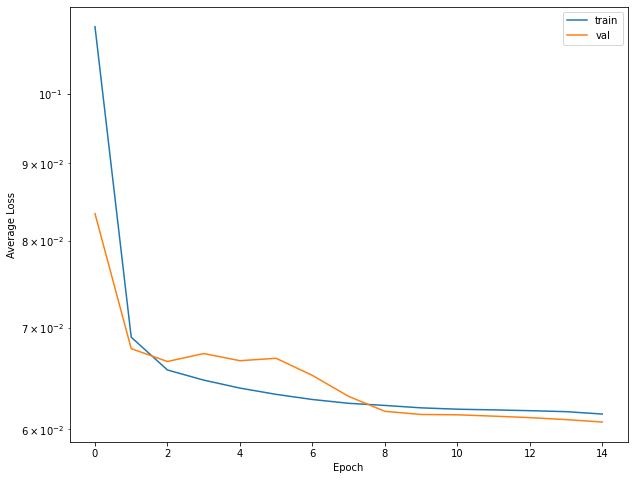

In [ ]:
# Plot losses
plt.figure(figsize=(10, 8))
plt.semilogy(history['train_loss'], label='train')
plt.semilogy(history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [ ]:
# torch.save(encoder.state_dict(), f'pre-trained models/{feature_dim}_vanilla_enc.pt')
# torch.save(decoder.state_dict(), f'pre-trained models/{feature_dim}_vanilla_dec.pt');

vanilla_encoder = Encoder(feature_dim)
# vanilla_decoder = Decoder(feature_dim)

vanilla_encoder.load_state_dict(torch.load(f'pre-trained models/{feature_dim}_vanilla_enc.pt'))
vanilla_encoder.to(device);

# vanilla_decoder.load_state_dict(torch.load(f'pre-trained models/{feature_dim}_vanilla_dec.pt'));
# vanilla_decoder.to(device);

## 5. Generate new samples from the latent vectors

In [ ]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20, 8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w : (n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')


def show_image(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
  # calculate mean and std of latent code generated taking in test images as inputs 
  images, labels = next(iter(train_loader))
  images = images.to(device)
  latent = encoder(images)
  latent = latent.cpu()

  mean = latent.mean(dim=0)
  # mean = train_mean_encoding
  # print(mean)
  std = (latent - mean).pow(2).mean(dim=0).sqrt()
  # std = (train_encodings - mean).pow(2).mean(dim=0).sqrt()
  # print(std)

  # sample 100 latent vectors from the normal distribution
  latent = torch.randn(100, d)*std + mean

  # reconstruct images from the random latent vectors
  latent = latent.to(device)
  img_recon = decoder(latent)
  img_recon = img_recon.cpu()  

  fig, ax = plt.subplots(figsize=(20, 15))
  show_image(torchvision.utils.make_grid(img_recon, 10, 2))  
  plt.show()

In [ ]:
plot_reconstructed(decoder, r0=(-1, 1), r1=(-1, 1))

In [ ]:
train_mean_encoding.shape

In [ ]:
mean_class_image = decoder(mean.unsqueeze(0).to(device)).squeeze().detach().cpu()

In [ ]:
mean_class_image.shape

In [ ]:
plt.imshow(mean_class_image.numpy(), cmap='gist_gray')
plt.axis('off')
plt.show()

## 6. Visualize Latent vectors

In [ ]:
# def get_encodings(dataset):
#   encoder.eval()
#   decoder.eval()
#   encoded_samples = []
#   for sample in tqdm(dataset):
#       img = sample[0].unsqueeze(0).to(device)      
#       label = sample[1]
#       # Encode image      
#       with torch.no_grad():
#           encoded_img = encoder(img)
#           decoded_img = decoder(encoded_img)
#       # Append to list
#       encoded_img = encoded_img.flatten().cpu().numpy()
#       decoded_img = decoded_img.cpu()
#       encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
#       encoded_sample['label'] = label                  
#       encoded_samples.append(encoded_sample)

#   return encoded_samples

In [ ]:
# def get_samples_encodings(dataloader, true_label):
#   encoder.eval()  
#   encoded_samples, labels = [], []
#   for batch in tqdm(dataloader):
#       img_batch = batch[0].to(device)      
#       label_batch = batch[1]
#       # Encode image      
#       with torch.no_grad():
#           encoded_imgs = encoder(img_batch)
#       # Append to list
#       encoded_imgs = encoded_imgs.detach().squeeze().cpu()
#       encoded_samples.append(encoded_imgs)
#       labels.append(label_batch)

#   samples = torch.cat([torch.cat(encoded_samples), torch.cat(labels).unsqueeze(1)], dim=1)
#   return samples

In [ ]:
def errors(dataloader):
  distances, labels = [], []
  encoder.eval()
  # decoder.eval()
  vanilla_encoder.eval()
  # vanilla_decoder.eval()

  for img_batch, label_batch in tqdm(dataloader):
    img_batch = img_batch.to(device)
    with torch.no_grad():
      vanilla_encoded_imgs = vanilla_encoder(img_batch)
      # vanilla_decoded_imgs = decoder(vanilla_encoded_imgs).reshape(img_batch.shape[0], -1)
      encoded_imgs = encoder(img_batch)
      # decoded_imgs = decoder(encoded_imgs).reshape(img_batch.shape[0], -1)
    distances.append(torch.sum((encoded_imgs - vanilla_encoded_imgs) ** 2, dim=1).detach().cpu())
    labels.append(label_batch.squeeze())

  distances, labels = torch.cat(distances), torch.cat(labels)
  return distances, labels

In [ ]:
test_errors, test_labels = errors(test_loader)

100%|██████████| 40/40 [00:04<00:00,  9.13it/s]


In [ ]:
test_stats_tensor = torch.stack([test_errors, test_labels], dim=1)
test_stats_tensor.size()

torch.Size([10000, 2])

In [ ]:
test_stats = pd.DataFrame(test_stats_tensor.data.numpy(), columns=['loss', 'label'])
test_stats

,loss,label
0,1.429692,7.0
1,1.299506,2.0
2,3.082968,1.0
3,0.924840,0.0
4,0.153816,4.0
...,...,...
9995,0.082101,2.0
9996,0.515476,3.0
9997,2.450526,4.0
9998,2.684715,5.0


In [ ]:
# px.scatter(train_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=train_samples.label.astype(str), opacity=0.7)

In [ ]:
# px.scatter(x=encoded_samples['loss'], y=encoded_samples.index, color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
px.scatter(test_stats, x=test_stats['loss'], y=test_stats.index, color=test_stats.label.astype(str), opacity=0.7)
# px.scatter(test_stats, x=test_stats['similarity'], y=test_stats.index, color=test_stats.label.astype(str), opacity=0.7)

In [ ]:
# plt.figure(figsize=(17, 9))
# plt.scatter(encoded_samples['Enc. Variable 0'], encoded_samples['Enc. Variable 1'], c=encoded_samples.label, cmap='tab10')
# plt.colorbar()
# plt.show()

In [ ]:
# plt.figure(figsize=(17, 9))
# plt.scatter(list(range(len(encoded_samples))), encoded_samples['Loss'], c=encoded_samples.label, cmap='tab10')
# plt.colorbar()
# plt.show()

In [ ]:
# pca = PCA(n_components=2)
# components = pca.fit_transform(encoded_samples.drop(['label', 'Loss'],axis=1))
# total_var = pca.explained_variance_ratio_.sum() * 100
# print(total_var)

In [ ]:
# fig = px.scatter(components, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'PC 1', '1': 'PC 2'})
# fig.show()

In [ ]:
# plt.figure(figsize=(17, 9))
# plt.scatter(components[:,0], components[:,1], c=encoded_samples.label, cmap='tab10')
# plt.colorbar()
# plt.show()

In [ ]:
# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

In [ ]:
# fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
# fig.show()

In [ ]:
# plt.figure(figsize=(17, 9))
# plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10')
# plt.colorbar()
# plt.show()